## Exercise in Photogrammetry II
# Ex. 02 Essential Matrix
### Submission: xx.xx.xxxx 
### Points: 12

In this exercise you will learn how to estimate the essential matrix given two images. You are given two images ```0400.jpg``` and ```0840.jpg```, and a set of point correspondences stored in the file ```x1x2.mat```. Here x1 denotes the pixel coordinates in the first image and x2 the pixel coordinates in the second image. Additionally, we provide the interior camera parameters **K**. 

**DATA:** Extract the data from the provided zip file with the password: photo

[[522   0 300]
 [  0 522 240]
 [  0   0   1]]


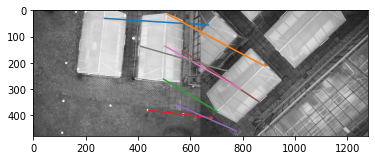

In [108]:
import matplotlib.pyplot as plt
import matplotlib.image as mi
import matplotlib.image
import scipy.io
import numpy as np


K = np.array([[522,0,300],
                [0,522,240],
                [0,0,1]])
print(K)
pts1 = scipy.io.loadmat("./data/x1x2.mat")["x1"]
pts2 = scipy.io.loadmat("./data/x1x2.mat")["x2"]

img1 = mi.imread("./data/0400.jpg")
img2 = mi.imread("./data/0840.jpg")
I = np.hstack([img1,img2])
plt.imshow(I,cmap='gray')
for i in range(pts1.shape[0]):
    plt.plot([pts1[i,1],pts2[i,1]+img1.shape[1]],[pts1[i,0],pts2[i,0]],'-')

In [103]:
print(img1.shape)
print(img2.shape)

(480, 640)
(480, 640)


## A Essential matrix and relative orentation

**Tasks:**

1. How many point correspondences do you need at least for computing the essential matrix? Give reasons for your answer. (1 Point)
2. What should one pay attention to when selecting point correspondences? Give reasons for your answer. (1 Point)
3. Specify all steps needed to estimate the essenetial matrix from two images. (2 Points)
4. {Code} Write a function that computes the essential matrix $E$ using the 8-point algorithm presented in the lecture. Test your function for the given correspondences. Print out the essential matrix $E$ as well as its rank. You don't need to normalize the data in this exercise.(4 Points)
5. {Code} Estimate the rotation $R$ and translation $b$ of the second camera with respect to the first camera. Use the provided function ```triangulatePoints(...)``` (in utils.py) to test for which solutions of $R$ and $b$ all points are in front of both cameras. Print out the results of $R$ and $b$. (6 Points)

In [212]:
def normTransform(p):
    """ Takes array of points and calculates transformation to normalize between [-1, 1]"""
    p_mean = np.mean(p[:, :2], axis=0, dtype=np.float64)
    p_scale = np.sqrt(2)/np.std(p[:,:2], dtype=np.float64)
    
    T = np.array([[p_scale, 0, -p_mean[0]*p_scale],
                  [0, p_scale, -p_mean[1]*p_scale],
                  [0,    0, 1]])
    return T

def computeF(p1, p2, cameraType):
    # kroneker product
    A = np.kron(p2, p1)
    assert np.linalg.matrix_rank(A) >= 8, "Insufficient rank for A"
    
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, D, V = np.linalg.svd(F)
    if cameraType == "uncalibrated":        
        return U, np.diag([D[0], D[1],0]), V.T
    
    elif cameraType == "calibrated":
        return U, np.diag([1, 1,0]), V.T     
    
def eightPointAlgo(p1, p2, cameraType="uncalibrated"):
    """Computes fundamental matrix and rank"""
    
    assert p1.shape[0] == p2.shape[0], "need number of points to match"
    assert p1.shape[0] >= 8, "need atleast 8 points"
    assert p1.shape[1] == p2.shape[1], "same columns for both"
    
    ## Transformation matrix for normalization
    T1, T2 = normTransform(p1), normTransform(p2)
    p1 = np.dot(T1, p1.T).T
    p2 = np.dot(T2, p2.T).T
    
    # Transformed fundamental matrix
    U, D, V_T = computeF(p1, p2, cameraType)
    F = U @ D @ V_T
    # final
    F = np.dot(T1.T, np.dot(F, T2))
    return  F

In [224]:
def triangulate_points(xs, xss, K, R01, X1):
    """Triangulate a batch of rays

    Input:
        xs  - [N x 3] points in first image
        xss - [N x 3] points in second image
        K   - [3 x 3] calibration matrix
        R12 - [3 x 3] rotation of 2nd cam w.r.t. 1st cam
        X1  - [3 x 1] projection center of 2nd cam
      
    Output:
        X - [N x 3] 3D points in global frame
    """

    # compute direction in corresponding camera frame
    k_xs = np.dot(np.linalg.inv(K), xs.T)
    k_xss = np.dot(np.linalg.inv(K), xss.T)

    # rotate rays of 2nd cam s.t. they are represented in the coord system of 1st cam,
    k_xss = np.dot(R01, k_xss)

    # intersect points,
    X = np.zeros(k_xs.shape)
    X0 = np.array([0,0,0])
    for i in range(k_xss.shape[1]):
        X[:, i] = compute_intersection(X0, k_xs[:, i], X1, k_xss[:, i])

    return X.T


def compute_intersection(X0, r, X1, s):
    """ Compute the intersection of rays of two cameras

    Input:
        X0 - [3 x 1] position of 1st camera
        r  - [3 x 1] direction vector of 1st cam
        X1 - [3 x 1] position of 2nd camera
        s  - [3 x 1] direction vector of 2nd cam
    Output:
        X - [3 x 1] point of intersection
    """
    r = r / np.linalg.norm(r)
    s = s / np.linalg.norm(s)

    # derived from geometrical constraints\n",
    A = np.array([[np.dot(r.T,r), np.dot(-s.T,r)],
                  [np.dot(r.T,s), np.dot(-s.T,s)]])

    b = np.array([[np.dot((X1-X0).T, r)],
                  [np.dot((X1-X0).T, s)]])
    
    x = np.linalg.solve(A, b) # length of rays

    # X0 - point in r where the lines should intersect
    # X1 - point in s where the lines should intersect
    F = X0 + x[0] * r
    H = X1 + x[1] * s
    
    # we need a mean point if two lines do not intersect in 3D
    X = (F + H) / 2

    return X

def unskew(b):
    return np.array([b[2, 1], b[0,-1], b[1,0]])

def rotBaseline(F, pts1, pts2):
    U, D, V_T = np.linalg.svd(F)
    
    U = U / np.linalg.norm(U)
    V_T = V_T / np.linalg.norm(V_T)
    
    Z = np.array([[0,1,0],[-1,0,0],[0,0,0]])
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    skewB = [U @ Z @ U.T, U @ Z.T @ U.T]
    rotT = [U @ W @ V_T, U @ W.T @ V_T]
    
    tPts = []
    # assumping dependent image parameterization
    for idx in range(2):
        baseVec = unskew(skewB[idx]).T
        for r_idx in range(2):
            rotVec = rotT[r_idx].T
            print("Possibility: {}".format(idx+r_idx+1))
            print(np.around(triangulate_points(pts1, pts2, F, rotVec, baseVec),2))
            print(" ")
    

In [222]:
F = eightPointAlgo(pts1, pts2, "calibrated")
print("Fundamental Matrix:\n {}\n rank is {}".format(np.around(F, 2), np.linalg.matrix_rank(F)))

Fundamental Matrix:
 [[-0.   -0.    0.02]
 [-0.    0.    0.01]
 [ 0.03 -0.02 -8.55]]
 rank is 2


In [225]:
triangPts = rotBaseline(F, pts1, pts2)
#print(triangPts)

Possibility: 1
[[-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]]
 
Possibility: 2
[[-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]
 [-0.13 -0.16 -0.  ]]
 
Possibility: 2
[[0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]]
 
Possibility: 3
[[0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]
 [0.13 0.16 0.  ]]
 
